## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import sqlite3
import pandas as pd
import gzip as gz
import zipfile
import os
import math
import matplotlib.pyplot as plt

In [2]:
''' # Unused data
with gz.open('zippedData/rt.reviews.tsv.gz') as f:
    rt_reviews = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/rt.movie_info.tsv.gz') as f:
    rt_movie_info = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/tmdb.movies.csv.gz') as f:
    tmdb_movies = pd.read_csv(f)
'''

with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)
with gz.open('zippedData/bom.movie_gross.csv.gz') as f:
    bom_movie_gross = pd.read_csv(f)
if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
        zipfile.ZipFile.extractall(my_zip,path='zippedData/')

im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)
im_db_ratings = pd.read_sql("""SELECT * FROM movie_ratings""",im_db)
im_db_persons = pd.read_sql("""SELECT * FROM persons""",im_db)
im_db_principals = pd.read_sql("""SELECT * FROM principals""",im_db)


First, look at the data from tn_movie_budgets.csv. This data contains a release date and budget as well as domestic and worldwide revenue for each movie. The financials are in string form with punctuation, but we should make them integers so we can perform math operations later. We can also determine the foreign revenue from the domestic and worldwide numbers. Finally, we only keep the relevant columns so we can merge the data with other sets later.

In [3]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype(int)
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)
#tn_movie_budgets.info()
tn_relevant_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn_relevant = tn_movie_budgets[tn_relevant_cols]
#tn_relevant.head()

Next, we look at the data from bom_movie_gross.csv. This data is similar to the tn_movie_budgets but has foreign revenue instead of worldwide, and does not contain budget data. We should make all of the financials integers and calculate the foreign revenue from domestic and worldwide so it is easier to join with the other sets. Once again we only keep relevant columns.

In [4]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].fillna('0')
bom_movie_gross.dropna(inplace=True)
bom_movie_gross['clean_domestic'] = bom_movie_gross['domestic_gross'].astype(int)
bom_movie_gross['clean_foreign'] = bom_movie_gross['foreign_gross'].str.replace(',','').astype(float)
bom_movie_gross['clean_foreign'] = bom_movie_gross['clean_foreign'].apply(math.trunc)
bom_movie_gross['clean_worldwide'] = bom_movie_gross['clean_domestic'] + bom_movie_gross['clean_foreign']
#bom_movie_gross.info()
bom_relevant_cols = ['title','year','clean_domestic','clean_foreign','clean_worldwide']
bom_relevant = bom_movie_gross[bom_relevant_cols]
#bom_relevant.head()

Here we combine the two financial data sets from before keeping only one entry for the movies present in both datasets. We decided to assume the median budget for the movies that did not have budget information in the datasets. This seems ok because only about 1/4 of the data does not have budget information. We then calculated total profit and return on investment for each movie in the dataset.

In [5]:
combined_financials = pd.concat([tn_relevant,bom_relevant],ignore_index=True)
combined_financials = combined_financials.drop_duplicates(subset='title',keep='first')
#combined_financials.plot('clean_domestic','clean_foreign',kind='scatter')

#Much of the budget column is empty because bom_movie_gross does not include budget information
#Going to fill the NA budgets with the median value
combined_financials['clean_budget'].fillna(combined_financials['clean_budget'].median(),inplace=True)
combined_financials['roi_domestic'] = 100 * (combined_financials['clean_domestic'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['roi_worldwide'] = 100 * (combined_financials['clean_worldwide'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['clean_profit'] = combined_financials['clean_worldwide'] - combined_financials['clean_budget']
#combined_financials.head()

,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
0,Avatar,2009,Dec,425000000.0,760507625,2015837654,2776345279,78.942971,553.257713,2.351345e+09
1,Pirates of the Caribbean: On Stranger Tides,2011,May,410600000.0,241063875,804600000,1045663875,-41.289850,154.667286,6.350639e+08
2,Dark Phoenix,2019,Jun,350000000.0,42762350,107000000,149762350,-87.782186,-57.210757,-2.002376e+08
3,Avengers: Age of Ultron,2015,May,330600000.0,459005868,944008095,1403013963,38.840250,324.384139,1.072414e+09
4,Star Wars Ep. VIII: The Last Jedi,2017,Dec,317000000.0,620181382,696540365,1316721747,95.640815,315.369636,9.997217e+08


We now take the data from im_db (which has no financial information) and merge it with the financial data. We then remove the movies from the dataframe with no financial information because having financial information is necessary for us to make any use of the movie data. This leaves us with around 3,500 movies.

In [6]:
im_db_combined = im_db_basics.merge(im_db_ratings,on='movie_id',how='inner')
im_db_combined = im_db_combined.drop_duplicates(subset = 'primary_title', keep='first')
im_db_combined.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_with_financial = im_db_combined.merge(combined_financials,on = 'title',how = 'inner')
#im_db_with_financial.head()

,movie_id,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2012,Dec,45000000.0,0,73706,73706,-100.000000,-99.836209,-44926294.0
1,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,2016,NaN,17000000.0,1100000,0,1100000,-93.529412,-93.529412,-15900000.0
2,tt0326592,The Overnight,The Overnight,2010,88.0,None,7.5,24,2015,Jun,200000.0,1109808,56188,1165996,454.904000,482.998000,965996.0
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,2013,Mar,25000000.0,720828,8592474,9313302,-97.116688,-62.746792,-15686698.0
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,2013,Dec,91000000.0,58236838,129624345,187861183,-36.003475,106.440860,96861183.0


In [7]:
genre_set = set()
genre_df = im_db_with_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
#genre_set

In [8]:
genre_plot_roi = []
genre_plot_profit = []
genre_comparison_df = pd.DataFrame
for genre in genre_set:
    roi_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['roi_worldwide']
    roi_series.rename(genre,inplace=True)
    genre_plot_roi.append(roi_series)
    profit_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['clean_profit']
    profit_series.rename(genre,inplace=True)
    genre_plot_profit.append(profit_series)
    #print(genre,profit_series.median())


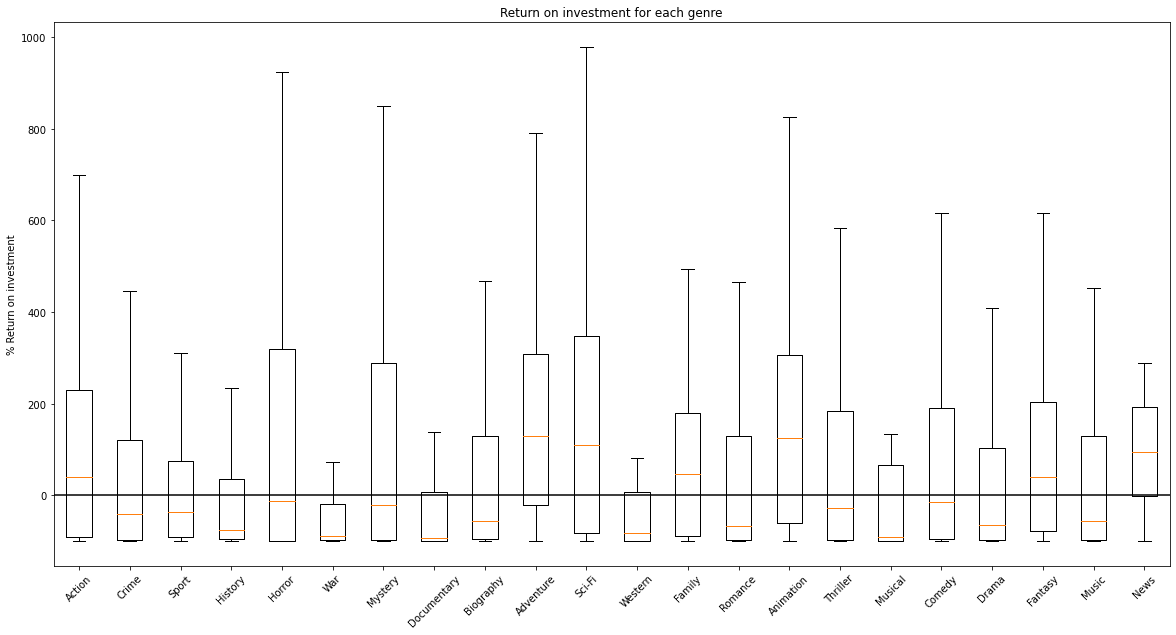

In [9]:
fig,ax = plt.subplots(figsize = (20,10))
ax.boxplot(genre_plot_roi,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax.tick_params(axis='x',labelrotation=45)
ax.axhline(y=0, color='k');
ax.set_title('Return on investment for each genre');
ax.set_ylabel('% Return on investment');

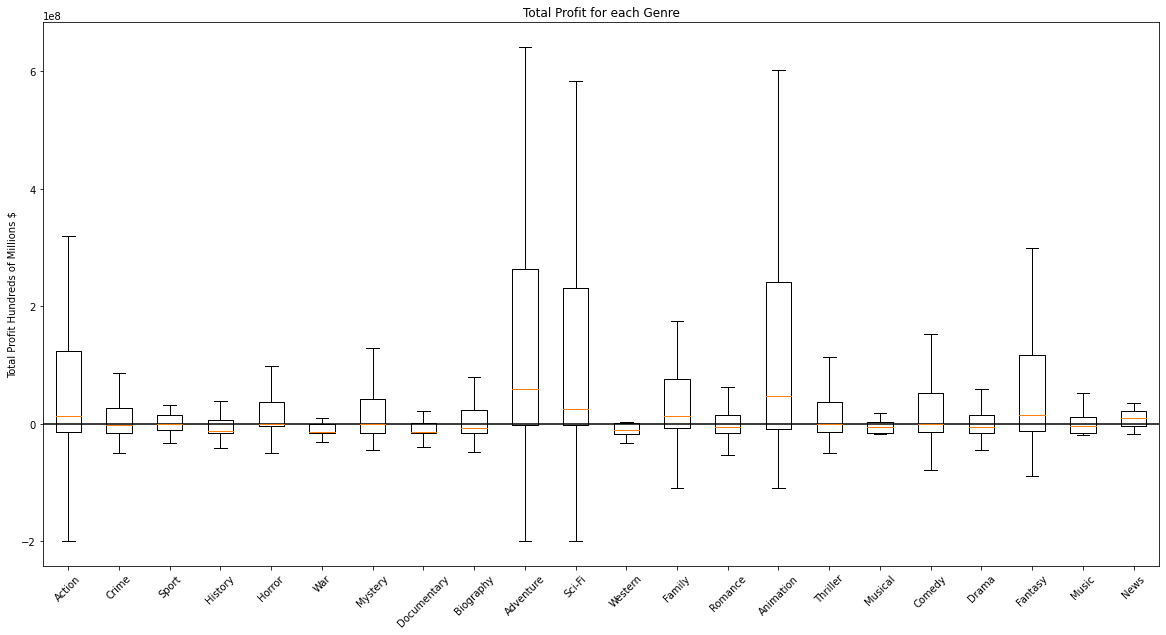

In [10]:
fig2,ax2 = plt.subplots(figsize = (20,10))
ax2.boxplot(genre_plot_profit,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax2.tick_params(axis='x',labelrotation=45)
ax2.axhline(y=0, color='k');
ax2.set_title('Total Profit for each Genre');
ax2.set_ylabel('Total Profit Hundreds of Millions $');

['*Aciton','*Fantasy','Family','Adventure','Animation','Sci-Fi']